<a href="https://colab.research.google.com/github/uncertainity/Capstone-Project-/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from tensorflow.keras import models, layers, callbacks

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
## Base Distribution 
theta_dist = tfd.Uniform(low = 0,high = 2*np.pi)
a_dist = tfd.Normal(loc = 3, scale = 1)
mu,sigma = 0,0.3
base_dist = tfd.MultivariateNormalDiag(loc = [mu,mu],scale_diag = [sigma,sigma])

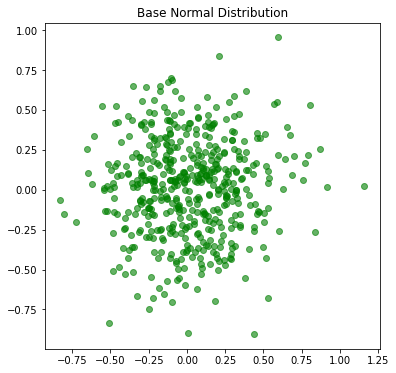

In [3]:
n = 500
z = base_dist.sample(n).numpy()
plt.figure(figsize = (6,6))
plt.scatter(z[:,0],z[:,1],color = "green",alpha = 0.6)
plt.title("Base Normal Distribution")
plt.show()

z ~ bivariatenormal([0,0],I) 

f1(z) = (z1,z2-2) 

f2(z) = (z1,z2/2) 

f3(z) = (z1,z2 + az1^2) 

f4(z) = Rz (R is rotation matrix) f5(z) = tanh(z)

In [4]:
## f1 and f2 are shift and scale operators
class Polynomial(tfb.Bijector):
  def __init__(self,a,name = "Polynomial", **kwargs):
    super(Polynomial,self).__init__(forward_min_event_ndims = 1,name = name,is_constant_jacobian = True,**kwargs)
    a = tf.cast(a,dtype = tf.float32)
    self.a = a
  def _forward(self,x):
    x = tf.cast(x,dtype = tf.float32)
    y = tf.concat([x[...,0:1],x[...,1:] + tf.math.square(x[...,0:1])*self.a],axis = -1 )
    return y
  def _inverse(self,y):
    y = tf.cast(y,dtype = tf.float32)
    return tf.concat([y[...,0:1],y[...,1:] - tf.math.square(y[...,0:1])*self.a],axis = -1)    
  def _forward_log_det_jacobian(self,x):
    return tf.constant(0,dtype = x.dtype)



In [5]:
class Rotation(tfb.Bijector):
  def __init__(self,theta,name = "Rotation",**kwargs):
    super(Rotation,self).__init__(name = name,forward_min_event_ndims = 1,**kwargs)
    self.rot_matrix = tf.convert_to_tensor([[tf.cos(theta),-tf.sin(theta)],
                                           [tf.sin(theta),tf.cos(theta)]],dtype = tf.float32)
  def _forward(self,x):
    x = tf.cast(x,dtype = tf.float32)
    y = tf.linalg.matvec(self.rot_matrix,x)
    #print(self.rot_matrix.numpy())
    return y
    
  def _inverse(self,y):
    y = tf.cast(y,dtype = tf.float32)
    x = tf.linalg.matvec(tf.transpose(self.rot_matrix),y)
    return x

  def _forward_log_det_jacobian(self,x):
    return tf.constant(0.,dtype = x.dtype)


In [6]:
## Chaining the bijectors ##
def getFlow(theta,a):
  f1 = tfb.Shift([0,-2])
  f2 = tfb.Scale([1,0.5])
  f3 = Polynomial(a)
  f4 = Rotation(theta)
  f5 = tfb.Tanh()

  return tfb.Chain(list(reversed([f1,f2,f3,f4,f5])))



In [7]:
## Applying the bijector on the base_distribution ##
getFlowDist = lambda theta,a,base_dist:tfd.TransformedDistribution(distribution = base_dist,bijector = getFlow(theta,a))

In [8]:
## Checking some examples of our transformed distribution ##

theta = theta_dist.sample(1).numpy()[0]
print("theta:",theta)
a = a_dist.sample(1).numpy()[0]
print("a:",a)
flow_dist = getFlowDist(theta,a,base_dist)
print("Samples from transformed distribution:")
print(flow_dist.sample(2))

theta: 2.5100024
a: 2.7403994
Samples from transformed distribution:
tf.Tensor(
[[-0.15446094  0.49180785]
 [ 0.599981    0.6081851 ]], shape=(2, 2), dtype=float32)


In [9]:
def plotFlow(theta,a,flow,n_samples,color = "green"):
  samples = flow.sample(n_samples).numpy().squeeze()
  plt.scatter(samples[...,0],samples[...,1],color = color,alpha = 0.5)
  plt.title("theta = {:.2f}, a = {:.2f}".format(theta,a))
  plt.xlim([-1,1])
  plt.ylim([-1,1])
  

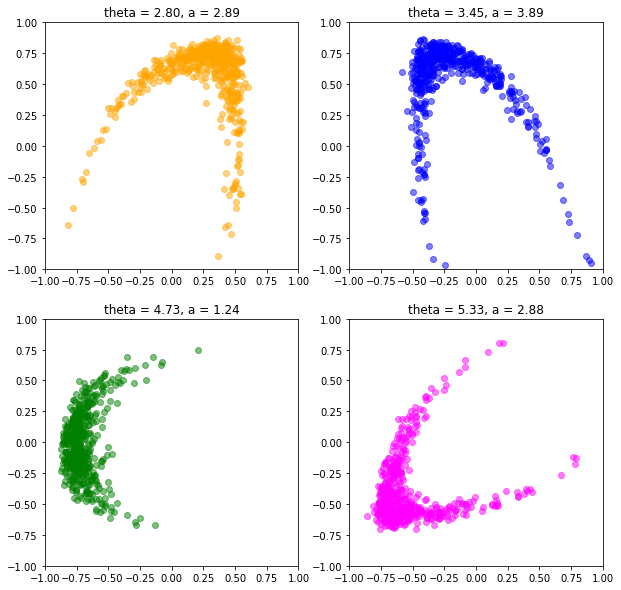

In [10]:
n = 500

plt.figure(figsize = (10, 10))
for i, col in enumerate(["orange", "blue", "green", "magenta"]):
    # Parameter Sampling
    theta = theta_dist.sample(1).numpy()[0]
    a = a_dist.sample(1).numpy()[0]
    # Building a Normalizing Flow Distrubtion
    flow_dist = getFlowDist(theta, a, base_dist)
    # Plotting the Samples.
    plt.subplot(2, 2, i+1)
    plotFlow(theta, a, flow_dist, n, col)
plt.show()

In [11]:
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    inputs_1 = np.expand_dims(inputs,2)
    #print(inputs_1.shape)
    Z = transformed_distribution.prob(inputs_1)
    
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    #print(Z.shape)
    return Z

In [12]:
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

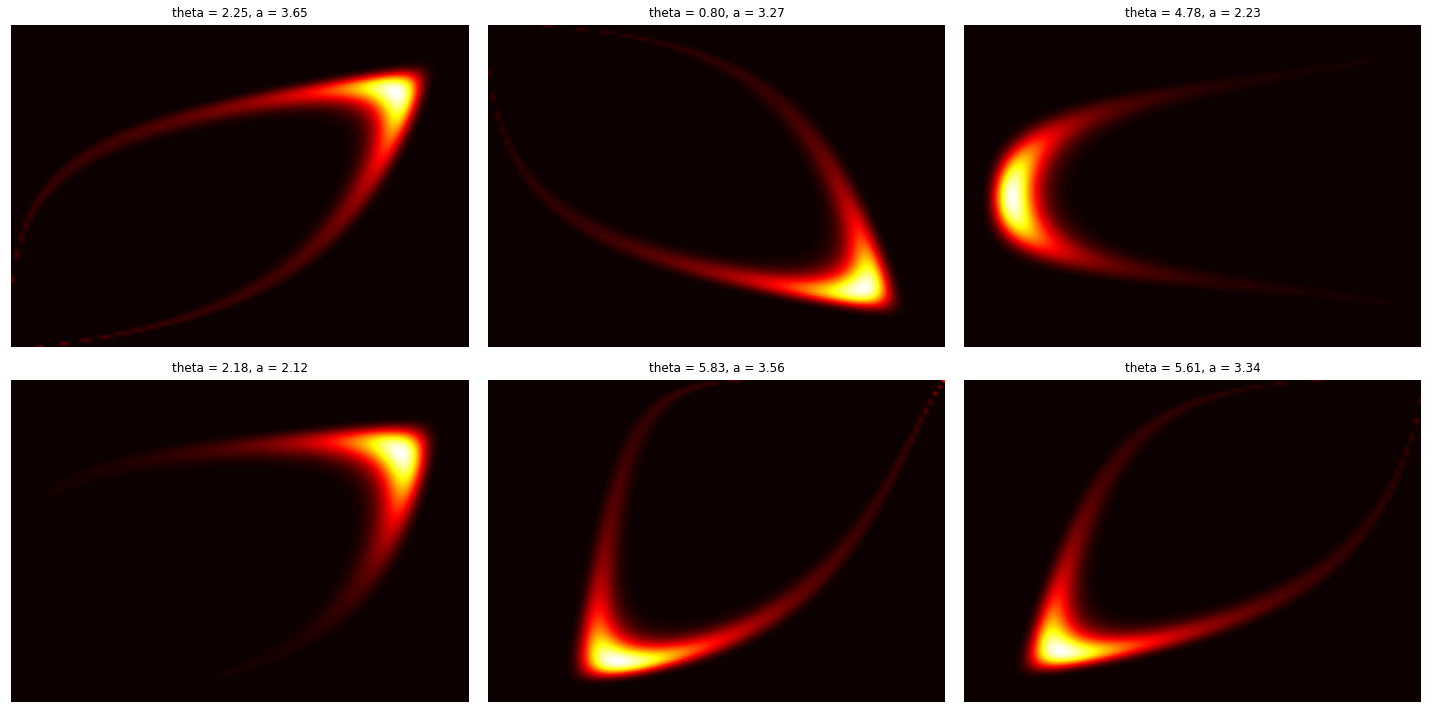

In [13]:
plt.figure(figsize = (20,10))
for i in range(6):
  theta = theta_dist.sample(1).numpy()[0]
  a = a_dist.sample(1).numpy()[0]
  flow_dist = getFlowDist(theta,a,base_dist)
  flow_dist = tfd.BatchReshape(flow_dist,[1])
  plt.subplot(2,3,i+1)
  plt.contourf(X,Y,get_densities(flow_dist).squeeze(),cmap = "hot",levels = 100)
  plt.title("theta = {:.2f}, a = {:.2f}".format(theta, a))
  plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
## generating the image dataset ##

images = []
img_params = []
N = 2500

for _ in range(N):
  theta = theta_dist.sample(1).numpy()[0]
  a = a_dist.sample(1).numpy()[0]
  flow_dist = getFlowDist(theta,a,base_dist)
  flow_dist = tfd.BatchReshape(flow_dist,[1])
  Z = get_densities(flow_dist).squeeze()
  images.append(get_image_array_from_density_values(Z))

images = np.array(images)

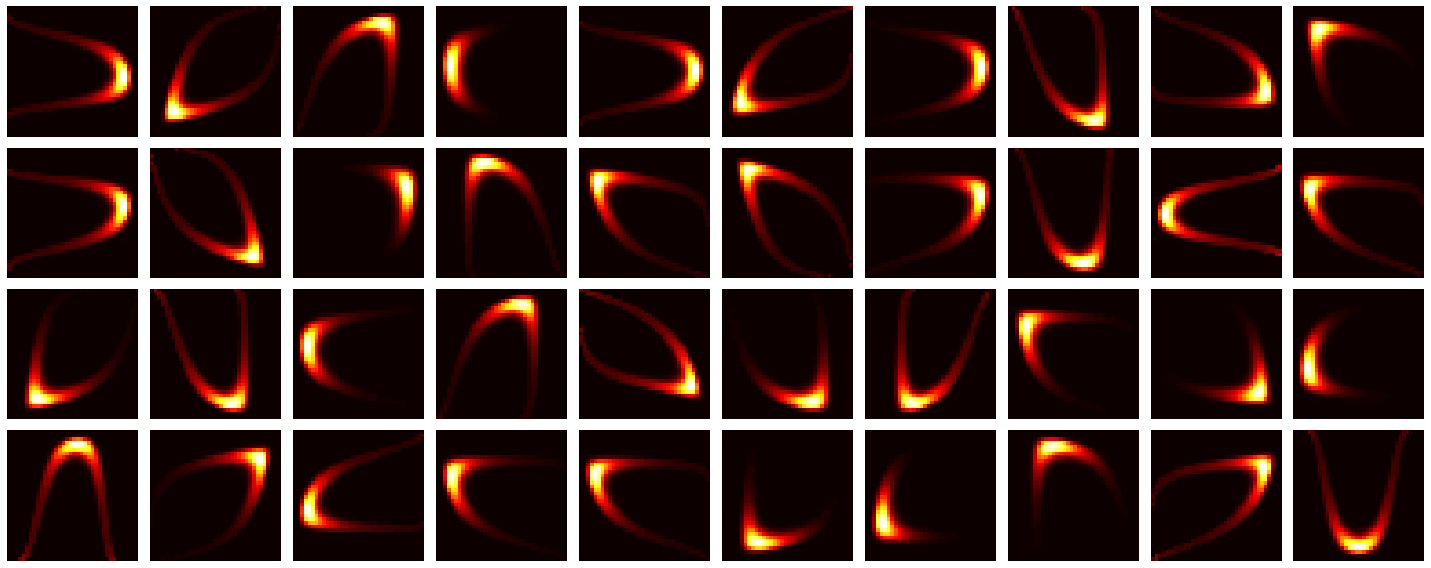

In [15]:
plt.figure(figsize=(20, 8))
for i in range(40):
    plt.subplot(4, 10, i+1)
    idx = np.random.randint(0, N)
    plt.imshow(images[idx])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
def test_train_split(data,test_fraction):
  data = data.astype(dtype = np.float32)
  N = data.shape[0]
  test_idx = np.random.choice(N,int(test_fraction*N),replace = False)
  train_idx = np.setdiff1d(np.arange(N),test_idx)
  return data[train_idx],data[test_idx]

In [17]:
train,test = test_train_split(images,0.2)
print(train.shape)
print(test.shape)


(2000, 36, 36, 3)
(500, 36, 36, 3)


In [18]:
def GetDataset(data,test_fraction,batch_size = 20):
  train,test = test_train_split(data,test_fraction)
  
  train = tf.data.Dataset.from_tensor_slices(train)
  train = train.map(lambda x: x/255.)
  ## Because the input and output aare same ##
  train = train.map(lambda x: (x,x))
  train = train.batch(batch_size,drop_remainder = True)
  
  test = tf.data.Dataset.from_tensor_slices(test)
  test = test.map(lambda x: x/255.)
  test = test.map(lambda x: (x,x))
  test = test.batch(batch_size,drop_remainder = True)
  
  return train,test

In [19]:
batch_size = 20
train_data, test_data = GetDataset(images, 0.2)

print(train_data.element_spec)
print(test_data.element_spec)

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


In [20]:
image_dims = images.shape[1:]
print(image_dims)

(36, 36, 3)


Enoder/decoder network z be the latent variable.

Loss = KL(q(z|x)||p(z)) - log_prob(p(x|z)

q(z|x) --> output of the encoder layer

p(x|z) --> output of decoder layer

p(z) --> prior

In [21]:
latent_dim = 2

In [22]:
## defining the prior p(z) ##
def get_prior(latent_dim):
  prior = tfd.MultivariateNormalDiag(loc = tf.Variable(tf.zeros(latent_dim)),scale_diag = tfp.util.TransformedVariable(initial_value = tf.ones(latent_dim,dtype = tf.float32),
                                                                                                                       bijector = tfb.Softplus(),dtype = tf.float32))
  return prior

In [23]:
def get_encoder(latent_dim):
  prior = get_prior(latent_dim)
  model = models.Sequential([
                            layers.InputLayer(input_shape = image_dims),
                            
                            layers.Conv2D(filters = 32,kernel_size = (3,3)),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(0.2),
                             
                            layers.Conv2D(filters = 64,kernel_size = (3,3)),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(0.2),
                             
                            layers.Conv2D(filters = 128,kernel_size = (3,3)),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(0.2),
                            
                            layers.Conv2D(filters = 256,kernel_size = (3,3)),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(0.2),
                             
                            layers.Conv2D(filters=8, kernel_size=(1,1)),
                            layers.BatchNormalization(),
                             
                            layers.Flatten(),
                            
                            layers.Dense(100),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(0.2),
                            
                            layers.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
                            tfpl.MultivariateNormalTriL(latent_dim),
                            
                            tfpl.KLDivergenceAddLoss(prior,use_exact_kl = False,test_points_fn = lambda q:q.sample(5),test_points_reduce_axis = (0,1))
                    ])
  
  return model

In [24]:
encoder_model = get_encoder(latent_dim)
encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 34, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 34, 34, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 34, 34, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0

In [25]:
def get_decoder(latent_dim, image_dim):
    model = models.Sequential([
                               layers.InputLayer(input_shape=(latent_dim,)),

                               layers.Dense(64),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Dense(128),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Dense(256),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Reshape(target_shape=(8, 8, 4)),

                               layers.UpSampling2D(size=(3,3)),
                               layers.Conv2D(filters=128, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.UpSampling2D(size=(2, 2)),
                               layers.Conv2D(filters=64, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Conv2D(filters=32, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Conv2D(filters=16, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Conv2D(filters=1, kernel_size=(3, 3), strides=(2,2)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Flatten(),

                               layers.Dense(tfpl.IndependentBernoulli.params_size(image_dim)),

                               tfpl.IndependentBernoulli(event_shape=image_dim)
    ])

    return model

In [26]:
decoder_model = get_decoder(latent_dim, image_dims)
decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128)              

In [27]:
nll = lambda real,estimated: -tf.reduce_mean(estimated.log_prob(real))

In [28]:
def get_vae(encoder,decoder):
  vae = models.Model(inputs = encoder.inputs,outputs = decoder(encoder.outputs))
  vae.compile(optimizer = "Adam",loss = nll)
  return vae

In [29]:
vae_model = get_vae(encoder_model, decoder_model)
vae_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 36, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 34, 34, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 34, 34, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 34, 34, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                             

In [30]:
es_callback = callbacks.EarlyStopping(monitor = "val_loss",min_delta = 0.1,patience = 8, restore_best_weights = True)
history = vae_model.fit(train_data,validation_data = test_data,epochs = 10,callbacks = [es_callback])

Epoch 1/10
100/100 [==============================] - 14s 28ms/step - loss: 765.1952 - val_loss: 3583.4026
Epoch 2/10
100/100 [==============================] - 2s 24ms/step - loss: 471.7478 - val_loss: 1375.9822
Epoch 3/10
100/100 [==============================] - 2s 23ms/step - loss: 443.2197 - val_loss: 672.7736
Epoch 4/10
100/100 [==============================] - 2s 23ms/step - loss: 428.7551 - val_loss: 435.9698
Epoch 5/10
100/100 [==============================] - 2s 23ms/step - loss: 421.0769 - val_loss: 422.9240
Epoch 6/10
100/100 [==============================] - 2s 23ms/step - loss: 417.5282 - val_loss: 418.4987
Epoch 7/10
100/100 [==============================] - 2s 23ms/step - loss: 410.1886 - val_loss: 406.4596
Epoch 8/10
100/100 [==============================] - 2s 22ms/step - loss: 408.4272 - val_loss: 426.8239
Epoch 9/10
100/100 [==============================] - 2s 22ms/step - loss: 403.2692 - val_loss: 410.4158
Epoch 10/10
100/100 [==============================]

In [31]:
vae_model.save_weights("/content/my_checkpoint")

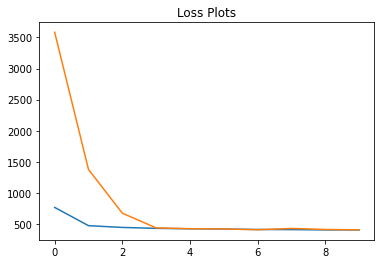

In [32]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss Plots")
plt.show()


In [33]:
N = 1000
idx = np.random.choice(np.arange(images.shape[0]),N)
embeddings = encoder_model(images[idx]/255.).mean()


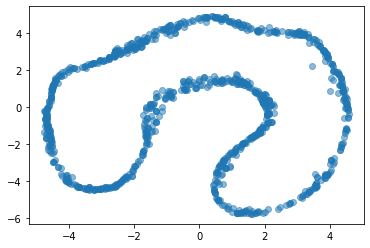

In [34]:
plt.scatter(embeddings[:,0],embeddings[:,1],alpha = 0.5)
plt.show()

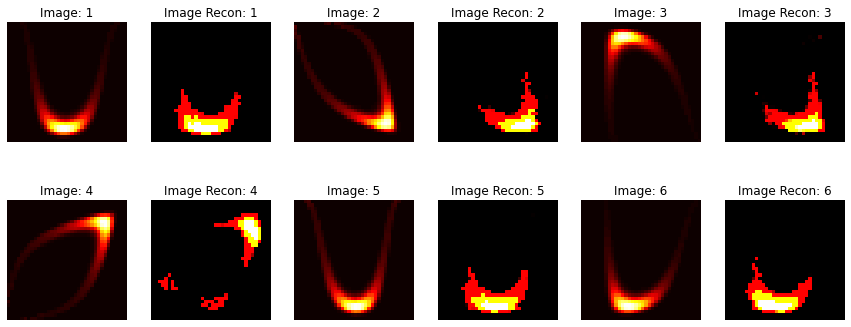

In [35]:
N = 6
idx = np.random.choice(np.arange(images.shape[0]), N) 
rec_images = vae_model(images[idx]).mean().numpy()

plt.figure(figsize=(15, 6))
for i in range(N):
    plt.subplot(2, 6, 2*i+1)
    plt.imshow(images[idx[i]])
    plt.title("Image: {}".format(i+1))
    plt.axis("off")

    plt.subplot(2, 6, 2*i+2)
    plt.imshow(rec_images[i])
    plt.title("Image Recon: {}".format(i+1))
    plt.axis("off")
plt.show()

In [36]:
N = 6
embeddings = np.random.uniform(-2,2(N,latent_dim))
rec_images = decoder_model(embeddings).mean()
fig = plt.figure(figsize=(14, 6)) 
gs = gridspec.GridSpec(2, 5) 

ax0 = plt.subplot(gs[:, 0:2])
ax0.scatter(embeddings[:, 0], embeddings[:, 1])
for i in range(N):
    ax0.annotate("Embedding "+chr(ord("A")+i), (embeddings[i, 0]-0.05, embeddings[i, 1]+7e-3))
ax0.set_xlim(-2.2, 2.2)

for i in range(2):
    for j in range(3):
        ax1 = plt.subplot(gs[i, 2+j])
        ax1.imshow(rec_images[2*i + j])
        ax1.set_axis_off()
        ax1.set_title("Embedding "+chr(ord("A")+(2*i + j)))

plt.show()
